In [172]:
import networkx as nx
import matplotlib.pyplot as plt

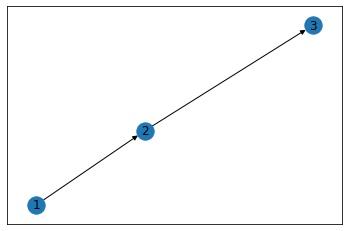

In [173]:
G = nx.DiGraph()
nx.add_path(G, [1,2])
nx.add_path(G, [2,3])
G.add_nodes_from([
    (1, {"layer":set([1])}),
    (2, {"layer":set([1,2])}),
    (3, {"layer":set([2])}),
])
nx.draw_networkx(G)
plt.show()

In [174]:
G.nodes.data()

NodeDataView({1: {'layer': {1}}, 2: {'layer': {1, 2}}, 3: {'layer': {2}}})

In [175]:
G.nodes.data("layer")

NodeDataView({1: {1}, 2: {1, 2}, 3: {2}}, data='layer')

In [176]:
for node, layer_set in G.nodes.data("layer"):
    print(f'{node},{layer_set}')

1,{1}
2,{1, 2}
3,{2}


In [177]:
G.nodes.data("layer")[1].add(3)
for node, layer_set in G.nodes.data("layer"):
    print(f'{node},{layer_set}')

1,{1, 3}
2,{1, 2}
3,{2}


In [178]:
G.nodes.data("layer")[1].remove(3)
for node, layer_set in G.nodes.data("layer"):
    print(f'{node},{layer_set}')

1,{1}
2,{1, 2}
3,{2}


In [179]:
G.edges()

OutEdgeView([(1, 2), (2, 3)])

In [180]:
G.nodes()

NodeView((1, 2, 3))

In [181]:
G.add_edges_from([
    (1,2,{0:None, 1:{"waight":1}}),
    (2,3,{0:None, 2:{"waight":2}}),
])
for layer in range(1,3):
    print(f"layer={layer}")
    for n0,n1,info in G.edges.data(layer):
        print(f"edge=({n0},{n1}),info={info}")

layer=1
edge=(1,2),info={'waight': 1}
edge=(2,3),info=None
layer=2
edge=(1,2),info=None
edge=(2,3),info={'waight': 2}


In [182]:
G.edges.data()

OutEdgeDataView([(1, 2, {0: None, 1: {'waight': 1}}), (2, 3, {0: None, 2: {'waight': 2}})])

In [183]:
for n1,n2,info in G.edges.data(1):
    if info is None:
        continue
    info["waight"] = 0
for layer in range(1,3):
    print(f"layer={layer}")
    for n0,n1,info in G.edges.data(layer):
        print(f"edge=({n0},{n1}),info={info}")

layer=1
edge=(1,2),info={'waight': 0}
edge=(2,3),info=None
layer=2
edge=(1,2),info=None
edge=(2,3),info={'waight': 2}


In [184]:
layer_set = set([1,2])

In [185]:
nG = nx.DiGraph()
layer_exist = True
new_layer_set = set()
for layer in layer_set:
    layer_exist = False
    for i, (n1,n2,info) in enumerate(G.edges.data(layer)):
        if info is None:
            continue
        layer_exist = True
        if info["waight"] > 0:
            nx.add_path(nG, [n1,n2])
            nG.add_edges_from([(n1,n2,{0:None, layer:{"waight":info["waight"]}})])
            if nG.nodes.data():
                nG.add_nodes_from([(n1, {"layer":set([layer])})])
                nG.add_nodes_from([(n2, {"layer":set([layer])})])
            else:
                if n1 in nG.nodes.data():
                    nG.nodes.data()[n1]["layer"].add(layer)
                else:
                    nG.add_nodes_from([(n1, {"layer":set([layer])})])
                if n2 in nG.nodes.data():
                    nG.nodes.data()[n2]["layer"].add(layer)
                else:
                    nG.add_nodes_from([(n2, {"layer":set([layer])})])
                
            new_layer_set.add(layer)
    if not layer_exist:
        break
G = nG
layer_set = new_layer_set
for layer in layer_set:
    print(f"layer={layer}")
    for n0,n1,info in G.edges.data(layer):
        print(f"edge=({n0},{n1}),info={info}")

layer=2
edge=(2,3),info={'waight': 2}


In [186]:
G.nodes.data()[3]

{'layer': {2}}

In [187]:
G.nodes.data()[2]["layer"] = G.nodes.data()[2]["layer"] | set([3])
G.nodes.data()

NodeDataView({2: {'layer': {2, 3}}, 3: {'layer': {2}}})

In [188]:
G.edges.data()

OutEdgeDataView([(2, 3, {0: None, 2: {'waight': 2}})])

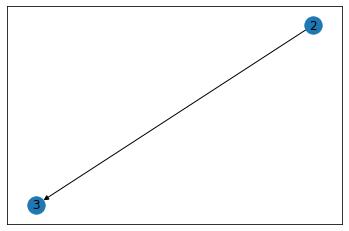

In [189]:
nx.draw_networkx(G)
plt.show()

0: None を消しても構わないか検討

nx.DiGraph をレイヤー毎に持っているクラスを定義、このクラスでは
①確率的にlayerを削除したり追加したりする
②所属がするノードがいるレイヤーだけを持つセットと、所属するノードがいないレイヤーも含めたセットを保持
③一つのレイヤーにつき一つのグラフを持ち、更新する
④ミームの存在を定義
⑤ミームがどのノードのどのレイヤーに属するかを、グラフオブジェクトのノードの情報で保持
⑥ミームの同一レイヤーにおけるネットワークでの伝搬
⑦各ノードにとっての、ミームの偶発的発生と削除
⑧単一ノード内部で、レイヤー間のミームの確率的な伝搬
機能を追加する



In [190]:
G = nx.DiGraph()
nx.add_path(G, [1,2])
nx.add_path(G, [2,3])
nx.add_path(G, [3,1])
G.add_nodes_from([
    (1, {1:{"meam":set([1,2,3])}, 2:{"meam":set([3])}}),
    (2, {1:{"meam":set([1,2])}}),
    (3, {2:{"meam":set([3])}}),
])

In [191]:
G.nodes()

NodeView((1, 2, 3))

In [192]:
G.nodes()[1]

{1: {'meam': {1, 2, 3}}, 2: {'meam': {3}}}

In [193]:
G.nodes.data()

NodeDataView({1: {1: {'meam': {1, 2, 3}}, 2: {'meam': {3}}}, 2: {1: {'meam': {1, 2}}}, 3: {2: {'meam': {3}}}})

In [194]:
G.nodes.data()[1]

{1: {'meam': {1, 2, 3}}, 2: {'meam': {3}}}

In [195]:
G.nodes()[1][1]

{'meam': {1, 2, 3}}

In [196]:
G.nodes()[1][1]["meam"]

{1, 2, 3}

In [197]:
nx.add_path(G, [4,5])
G.add_nodes_from([(4, {2:{"meam":set([3])}})])
G.nodes()[4][3] = {"meam":set([4,5])}

In [198]:
G.nodes()[4]

{2: {'meam': {3}}, 3: {'meam': {4, 5}}}

In [199]:
G.nodes.data()[5]

{}

In [200]:
G.nodes()[1][1]

{'meam': {1, 2, 3}}

In [201]:
G.nodes()[1][3] = {"meam":set()}
G.nodes()[1]

{1: {'meam': {1, 2, 3}}, 2: {'meam': {3}}, 3: {'meam': set()}}

In [202]:
G.edges.data()

OutEdgeDataView([(1, 2, {}), (2, 3, {}), (3, 1, {}), (4, 5, {})])

In [203]:
G.edges.data()

OutEdgeDataView([(1, 2, {}), (2, 3, {}), (3, 1, {}), (4, 5, {})])

In [204]:
G.add_edges_from([(2,3,{1:{"waight":1}})])
G.add_edges_from([(4,5,{2:{"waight":2}})])
G.edges.data()

OutEdgeDataView([(1, 2, {}), (2, 3, {1: {'waight': 1}}), (3, 1, {}), (4, 5, {2: {'waight': 2}})])

In [205]:
G.edges.data(1)

OutEdgeDataView([(1, 2, None), (2, 3, {'waight': 1}), (3, 1, None), (4, 5, None)])

In [206]:
G.edges.data(2)

OutEdgeDataView([(1, 2, None), (2, 3, None), (3, 1, None), (4, 5, {'waight': 2})])

In [207]:
for n0, n1, info in G.edges.data():
    print((n0,n1), info)

(1, 2) {}
(2, 3) {1: {'waight': 1}}
(3, 1) {}
(4, 5) {2: {'waight': 2}}


In [208]:
for n0, n1, info in G.edges.data():
    for layer in info:
        w = info[layer]["waight"]
        info[layer]["waight"] += 1
    print((n0,n1), info)

(1, 2) {}
(2, 3) {1: {'waight': 2}}
(3, 1) {}
(4, 5) {2: {'waight': 3}}


In [209]:
G.remove_edge(2,3)
G.edges()

OutEdgeView([(1, 2), (3, 1), (4, 5)])

In [210]:
list(G.edges())

[(1, 2), (3, 1), (4, 5)]

In [216]:
G.nodes.data()

NodeDataView({1: {1: {'meam': {1, 2, 3}}, 2: {'meam': {3}}, 3: {'meam': set()}}, 2: {1: {'meam': {1, 2}}}, 3: {2: {'meam': {3}}}, 4: {2: {'meam': {3}}, 3: {'meam': {4, 5}}}, 5: {}})

In [217]:
G.nodes.data()[1]

{1: {'meam': {1, 2, 3}}, 2: {'meam': {3}}, 3: {'meam': set()}}

In [212]:
set([1,2,3]) - set([4])

{1, 2, 3}

In [213]:
d = {1:{2:4},2:{3:6}}
d.values()

dict_values([{2: 4}, {3: 6}])